In [162]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(100)

import scipy as sp
from scipy.stats import t

import statsmodels.stats.diagnostic as smd # Диагностика моделей
import statsmodels.formula.api as smf # Модели
import statsmodels.api as sm
import statsmodels.stats.api as sms # Тесты
import statsmodels.stats.stattools as smst # ещё тесты

import unicodedata

# Пример гетероскедастичности

In [3]:
x = np.linspace(0,5,80)

y1 = 4 + 2*x +np.random.normal(scale = x,size=x.shape)
y2 =  4 + 2*x +np.random.normal(size=x.shape)

Text(0.5, 1.0, 'With no scale')

<Figure size 1000x1000 with 0 Axes>

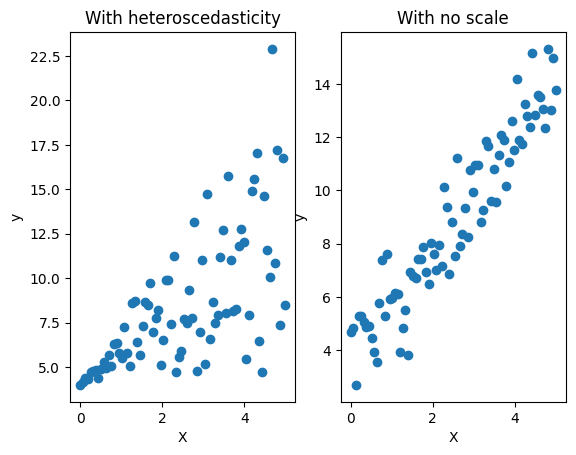

In [4]:
plt.figure(figsize = (10,10))
fig,axes = plt.subplots(ncols=  2)
axes[0].scatter(x, y1)
axes[0].set_xlabel("X")
axes[0].set_ylabel("y")
axes[0].set_title("With heteroscedasticity")


axes[1].scatter(x, y2)
axes[1].set_xlabel("X")
axes[1].set_ylabel("y")
axes[1].set_title("With no scale")


Видно диспресия растет вместе с изменением x

**Последствия гетероскедастичности**

Если предположение об одинаковых дисперсиях ошибок не
выполняется, то
* стандартные ошибки коэффициентов регрессии вычисляются
по неверным формулам
* t – тесты для проверки гипотез о конкретных значениях
коэффициентов не дают правильных результатов
* F – тесты для проверки гипотез о линейных ограничениях на
коэффициенты регрессии не дают правильных результатов
* Оценки МНК коэффициентов регрессии больше не являются
BEST, теряется эффективность оценок .

# Задача 3: Борьба с Гетероскедастичностью

Рассмотрим линейную регрессионную модель

$$y_i = 10+2x_i+\varepsilon_i$$

$$x_i \sim N(100, 16)$$

$$\varepsilon_i \sim N(0,x_i^2)$$

Сгенерируем выборку размера $n=50$. Оценим модель с помощью МНК.

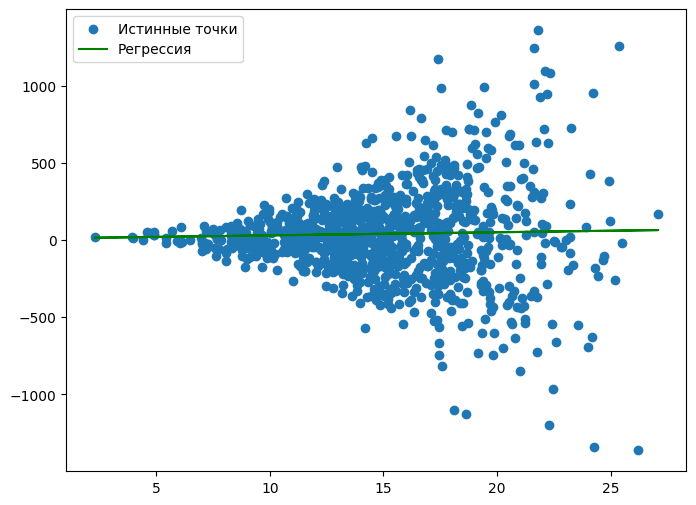

In [284]:
x = np.random.normal(loc=15, scale=4.0, size=1000)
eps = np.random.normal(loc=0.0, scale=x**2, size=1000)
y = 10+2*x+eps

plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Истинные точки')
plt.plot(x, y-eps, c='g', label='Регрессия')
plt.legend()
plt.show()

In [285]:
data = pd.DataFrame(np.vstack([x, y]).T, columns=['x', 'y'])
data.head()
model = smf.ols(data=data, formula='y ~ x').fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9980
Date:                Thu, 21 Nov 2024   Prob (F-statistic):              0.318
Time:                        01:01:12   Log-Likelihood:                -7105.0
No. Observations:                1000   AIC:                         1.421e+04
Df Residuals:                     998   BIC:                         1.422e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6758     36.294     -0.019      0.985     -71.898      70.546
x              2.3212      2.324      0.999      0.318      -2.238       6.881
==============================================================================
Omnibus:                       80.859   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              429.189
Skew:                           0.044   Prob(JB):                     6.35e-94
Kurtosis:                       6.208   Cond. No.                         61.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Гипотезы о незначимости для константы и регрессора не отвергаются на любом разумном уровне значимости

### Тест Голдьфельда-Квандта

Проведём тест **Голдфельда-Квандта** на гетероскедастичность:
$$H_0: ∀ i: \sigma^2_i = \sigma^2$$
$$H_1: ∃ i, j: \sigma_i != \sigma_j$$

Для проведения теста Голдфелда – Квандта все наблюдения
упорядочиваются по Хj и делятся на 3 части. Если выборка
небольшая, то выделяют приблизительно 3/8 части всех
наблюдений для первой и третьей части и приблизительно 1/4
в середине.

Мы будем использовать тест из statmodels:

Описание алгоритма Голдфелда – Квандта:

* Упорядочиваем все наблюдения по модулю подозрительной переменной.

* Делим все наблюдения на три группы (если наблюдений достаточно много, то
приблизительно на трети). Удобно, если в первой и третьей группах количество
наблюдений одинаково.

* Наблюдениями средней группы пренебрегаем, а по первым n1 и последним n2наблюдениям оцениваем отдельные регрессии.

* Используя суммы квадратов остатков (RSS) в оцененных регрессиях,
рассчитываем тестовую статистику по формуле в первой и третий группе

* Сравниваем полученное значение F – статистики с критическим (при выбранном
уровне значимости).

* Если значение F – статистики превышает критическое, нулевая гипотеза о
гомоскедастичности отвергается.


In [288]:
sms.het_goldfeldquandt(y=model.model.endog, x=model.model.exog, alternative='increasing')

(np.float64(1.0498055093752643), np.float64(0.29389798088028024), 'increasing')

Гипотеза об отсутствии гетероскедастичности в модели не отвергается на любом общепринятом уровне значимости в соответствии с проведённым тестом Голдфельда-Куандта. Гетероскедастичность не выявлена

### Тест Бреуша-Пагана

1. МНК-оценка коэффициентов и остатков модели
2. Подсчёт статистики $g_i=\frac{\hat{ɛ}_i^2}{\hat{\sigma}^2}$
3. МНК-оценка регрессии типа $g_i=\gamma Z_{i}+\eta_i$, где $Z$ - признаки, выбранные для оценки гетероскедастичности (обычно $Z=X$, но Z также может быть подмножеством Х или ещё как-либо модифицированным)
4. Посчитать статистику $LM=0.5(ESS_{auxilary})\sim \chi^2(shape(Z))$, где $ESS=\sum (\hat{g_i}-\overline{g})^2$

В statsmodels вывод следующий:
1. Значение LM статистики
2. Значение p-value для LM
3. Значение F статистики (значимость регрессии на остатки, H_0 - модель не значима в целом)
4. Значение p-value для F

In [286]:
sms.het_breuschpagan(model.resid, model.model.exog)

(np.float64(163.0526054204552),
 np.float64(2.436289668348938e-37),
 np.float64(194.4285880612159),
 np.float64(1.6606704282323082e-40))

Тест Бреуша-Пагана на гетероскедастичность отвергает гипотезу о гомоскедастичности в остатках на уровне значимости 0.1

WLS weighted least squares:

In [287]:
# y_weighted = y/x
# const_weighted = 1/x
# x_weighted = x/x
# data = pd.DataFrame(np.vstack([const_weighted,x_weighted, y_weighted]).T, columns=['const_weighted', 'x_weighted', 'y_weighted'])
# data.head()

Визуально при взвешивании наблюдений изменился лишь угол наклона для независимой переменной, ну и в конце выборки значения стали чуть ближе к линии

In [289]:
model2 = sm.WLS(y, x, weights=1/model.resid**2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 WLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.973
Model:                            WLS   Adj. R-squared (uncentered):              0.973
Method:                 Least Squares   F-statistic:                          3.625e+04
Date:                Thu, 21 Nov 2024   Prob (F-statistic):                        0.00
Time:                        01:01:47   Log-Likelihood:                         -6199.0
No. Observations:                1000   AIC:                                  1.240e+04
Df Residuals:                     999   BIC:                                  1.240e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.2713      0.012    190.406      0.000       2.248       2.295
==============================================================================
Omnibus:                     3768.653   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.412
Skew:                           0.027   Prob(JB):                     7.31e-37
Kurtosis:                       1.002   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Hetteroscedasticity consistent estimators

In [181]:
model2.HC0_se

const_weighted    17.818279
x_weighted         0.183880
dtype: float64

По итогам выполнения данного пункта можно сделать вывод о том, что для выборки большего размера гетероскедастичность в остатках лучше идентифицируема, при этом стандартные ошибки оценок коэффициентов, устойчивых к гетероскедастичности, почти не отличаются от исходных стандартных ошибок модели. Это означает, что при увеличении выборки корректировка на гетероскедастичность через взвешивание наблюдений обладает бОльшим смыслом. Для проверки данного тезиса выведем статистику теста Бреуша-Пагана для взвешенной модели:

In [182]:
sms.het_breuschpagan(model2.resid, model2.model.exog)

(np.float64(3.243862136940945),
 np.float64(0.07169145410937196),
 np.float64(3.24791018554218),
 np.float64(0.07181622710430349))

Действительно, гетероскедастичности больше нет, модель обладает статистически эффективными оценками (хоть при этом и её качество стало околонулевым)

Оценим стандартные ошибки коэффициентов, устойчивые к гетероскедастичности, при помощи какой-нибудь из схем HC. Поменялось ли что-нибудь?


Воспользуемся способом, изученным на семинаре: исправим только доверительные инетрвалы для параметров модели, оцениваемой при помощи МНК,так, чтобы они были устойчивы к гетероскедастичности. Тогда

$$
\hat{\mathrm{Var}}(\hat{\beta}_{OLS})_{HC} = (X'X)^{-1}X'\hat{\mathrm{Var}}(u)_{HC}X(X'X)^{-1}.
$$

В качестве $\hat{\mathrm{Var}}(u)_{HC_0}$ возьмём диагональную матрицу от квадратов оценённых остатков исходной модели - $\mathrm{diag}(\hat{u}^2_1, \ldots, \hat{u}^2_n)$

In [90]:
model.cov_params()

,Intercept,x
Intercept,115.619784,-2.696078
x,-2.696078,0.065917


In [91]:
var_u = np.diag(np.power(model.resid, 2))
var_u.shape

(100, 100)

In [92]:
exog = model.model.exog
Var_HC = np.linalg.inv(exog.T @ exog) @ exog.T @ var_u @ exog @ np.linalg.inv(exog.T @ exog)
df_var_hc = pd.DataFrame(Var_HC, columns = model.model.exog_names, index = model.model.exog_names)
df_var_hc

,Intercept,x
Intercept,69.033088,-1.822119
x,-1.822119,0.050966


In [93]:
model.cov_params()

,Intercept,x
Intercept,115.619784,-2.696078
x,-2.696078,0.065917


Видим, что стандартная ошибка коэффициента для коснтанты уменьшилась примерно на 0.05 по сравнению с исходной моделью, тогда как все остальные коэффициенты незначительно увеличились, покажем изменения наглядно:

In [94]:
df_var_hc / model.cov_params()

,Intercept,x
Intercept,0.597070,0.675841
x,0.675841,0.773181


##Выводы

In [95]:
model.pvalues.astype(np.float16)

/Users/mszekhov/Desktop/current_projects/psmo/venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Intercept    0.243408
x            0.000000
dtype: float16

In [96]:
model2.pvalues.astype(np.float16)

/Users/mszekhov/Desktop/current_projects/psmo/venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


Intercept         0.367920
const_weighted    0.510254
dtype: float16

Видим, что для исходного и взвешенного Х в МНК и ДВМНК моделях гипотеза о незначимости коэффициента при независимой переменной не отвергается на любом разумном уровне значимости. Это говорит о том, что Х  не оказывает существенного влияния на У, которое получилось идентифицировать в рамках моделирования регрессии. И на графиках выше для выборки размером 10000 наблюдений это очевидно, поскольку угол наклона линии регрессии находится на уровне нуля.

В свою очередь, для исходной и взвешенной константы в МНК и ДВМНК гипотеза о незначимости коэффициента при константе не отвергается на уровне значимости как минимум 15%. Это означает, что точка пересечения линии регрессии с осью ОУ может лежать как выше оси ОХ, так и ниже её, то есть усреднённый результат зависимой переменной варьируется достаточно сильно, чтобы уверенно распознать значимое отличие от 0. Ну что ж, бывает, при этом с учётом столь большого значения ошибок модели это достаточно очевидный результат

# Задача 4: проверка гауссовости

* $H_0: ɛ \sim N(0, \sigma^2)$
* $H_1: иначе$

Text(0.5, 1.0, 'Exponential residuals')

<Figure size 1000x1000 with 0 Axes>

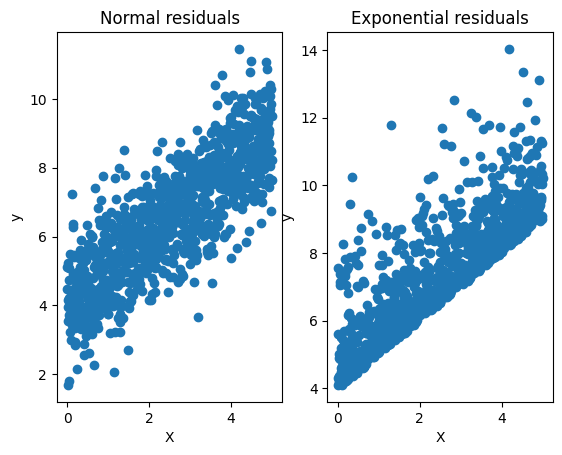

In [290]:
x = np.linspace(0,5,1000)

y1 = 4 + x +np.random.normal(size=x.shape)
y2 =  4 + x +np.random.exponential(size=x.shape)

plt.figure(figsize = (10,10))
fig,axes = plt.subplots(ncols=  2)
axes[0].scatter(x, y1)
axes[0].set_xlabel("X")
axes[0].set_ylabel("y")
axes[0].set_title("Normal residuals")


axes[1].scatter(x, y2)
axes[1].set_xlabel("X")
axes[1].set_ylabel("y")
axes[1].set_title("Exponential residuals")

In [292]:
data = pd.DataFrame(np.vstack([x, y2]).T, columns=['x', 'y'])
data.head()
model = smf.ols(data=data, formula='y ~ x').fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     1977.
Date:                Thu, 21 Nov 2024   Prob (F-statistic):          6.09e-239
Time:                        01:02:57   Log-Likelihood:                -1413.8
No. Observations:                1000   AIC:                             2832.
Df Residuals:                     998   BIC:                             2841.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0627      0.063     80.439      0.000       4.939       5.186
x              0.9692      0.022     44.464      0.000       0.926       1.012
==============================================================================
Omnibus:                      360.897   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1157.248
Skew:                           1.794   Prob(JB):                    5.09e-252
Kurtosis:                       6.860   Cond. No.                         6.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

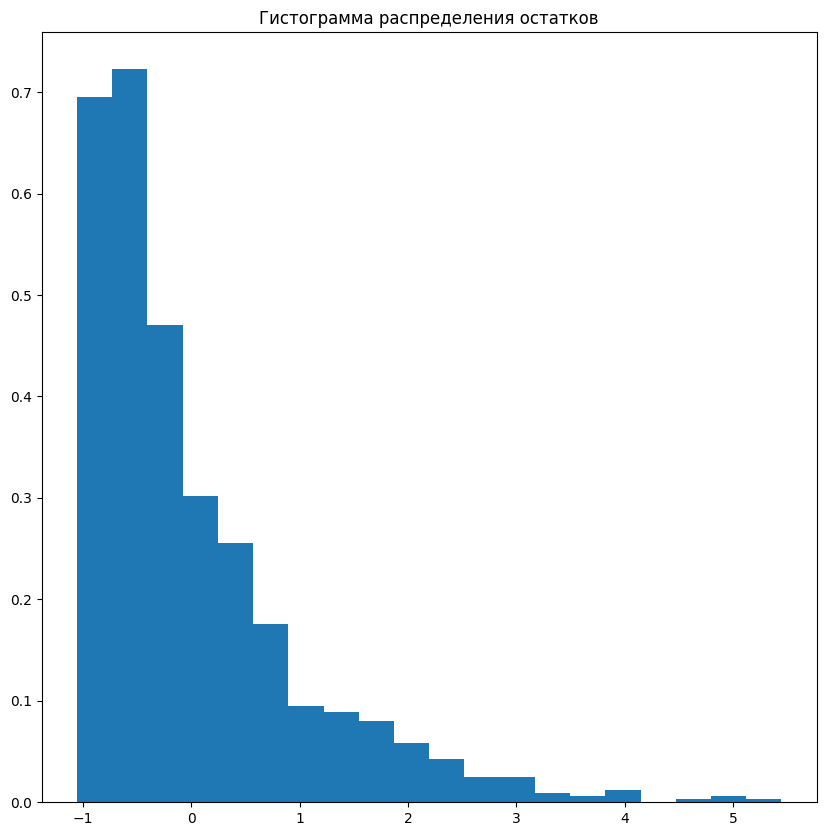

In [293]:
res = model.resid
counts, bins = np.histogram(res, bins=20, density=True)

plt.figure(figsize = (10,10))
plt.title('Гистограмма распределения остатков')
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

## Критерий Колмогорова

In [294]:
smd.kstest_normal(res)

(np.float64(0.14941220084138568), np.float64(0.0009999999999998899))

* Значение статистики Колмогорва-Смирнова
* p-value

Видим, что гипотеза о нормальности остатков отвергается на любом разумном уровне значимости

## Критерий Андерсона-Дарлинга

In [295]:
smd.normal_ad(res)

(np.float64(50.303002363452606), 0.0)

* Значение статистики Андерсона-Дарлинга
* p-value гипотезы о нормальности остатков

Отвергается

## Критерии Жарке-Бера и Omnibus

In [296]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     1977.
Date:                Thu, 21 Nov 2024   Prob (F-statistic):          6.09e-239
Time:                        01:03:15   Log-Likelihood:                -1413.8
No. Observations:                1000   AIC:                             2832.
Df Residuals:                     998   BIC:                             2841.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0627      0.063     80.439      0.000       4.939       5.186
x              0.9692      0.022     44.464      0.000       0.926       1.012
==============================================================================
Omnibus:                      360.897   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1157.248
Skew:                           1.794   Prob(JB):                    5.09e-252
Kurtosis:                       6.860   Cond. No.                         6.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* В последних 4 строчках видим статистику и p-value для тестова Jarque-Bera & Omnibus, в которых видно, что гипотеза о нормальности распределения остатков также отвергается

## Как можно побороть негауссовость остатков?

In [300]:
import statsmodels.api as sm
X = sm.add_constant(x)
model = sm.GLM(exog=X, endog=y2, family=sm.families.Gamma()).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      998
Model Family:                   Gamma   Df Model:                            1
Link Function:           InversePower   Scale:                        0.021119
Method:                          IRLS   Log-Likelihood:                -1422.5
Date:                Thu, 21 Nov 2024   Deviance:                       18.776
Time:                        01:04:19   Pearson chi2:                     21.1
No. Iterations:                     6   Pseudo R-squ. (CS):             0.8104
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1818      0.001    126.562      0.000       0.179       0.185
x1            -0.0174      0.000    -40.562      0.000      -0.018      -0.017
==============================================================================
"""

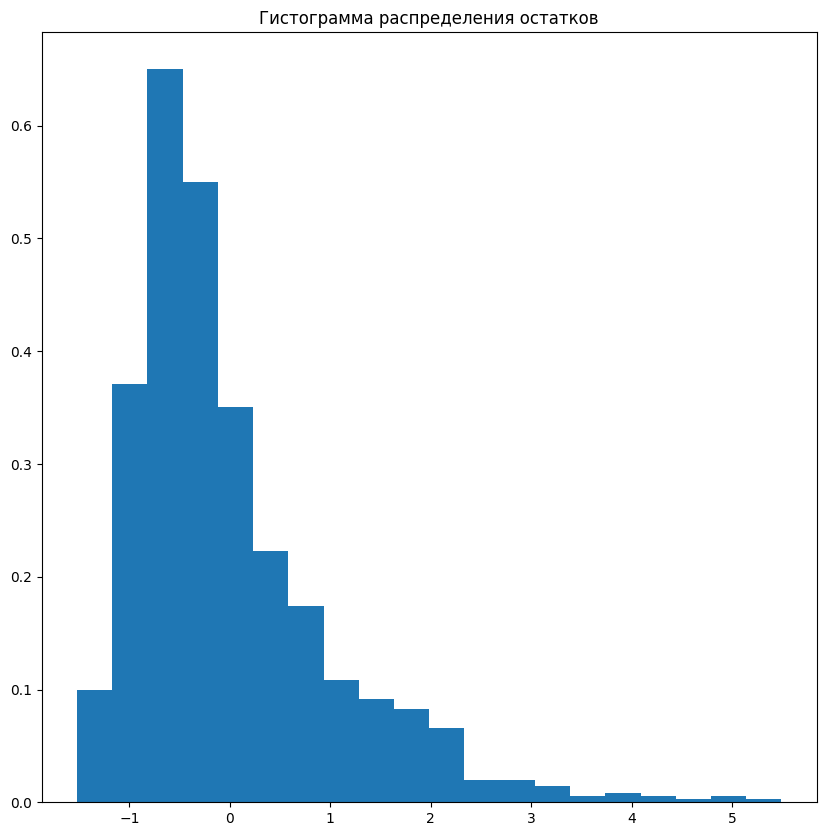

In [301]:
res = model.resid_response
counts, bins = np.histogram(res, bins=20, density=True)

plt.figure(figsize = (10,10))
plt.title('Гистограмма распределения остатков')
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

# Эндогенность

In [ ]:
import pandas as pd
import numpy as np


<center>
<img src="../logo.png" height="900">
</center>


#  Регрессия - моя профессия



In [304]:
import numpy as np
import pandas as pd

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

## Данные

In [305]:
df = pd.read_csv('https://raw.githubusercontent.com/FUlyankin/matstat-AB/main/week13_linreg/data/Advertising.csv', index_col=0)
print(df.shape)
df.head()

(200, 4)


,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


__Описание колонок:__

- `Sales` - продажи продукта на данном рынке (в тысячах штук)
- `TV` -  доллары, потраченные на ТВ рекламу для одного продукта на данном рынке (в тысячах долларов)
- `Radio` - доллары, потраченные на радио рекламу
- `Newspaper` - доллары, потраченные на рекламу в газетах

В нашей выборке мы имеем 200 **наблюдений** (200 разных рынков с разным объёмом рекламы)

## Вопросы

Давайте представим, что мы работаем на компанию, которая производит и продает этот товар. Компания может задать нам вопрос: как мы должны тратить наши рекламные деньги в будущем?

Этот общий вопрос может привести вас к более конкретным вопросам:

1. Существует ли связь между рекламой и продажами?
2. Насколько сильны эти отношения?
3. Какие типы рекламы способствуют росту продаж?
4. Зная расходы на рекламу на конкретном рынке, можем ли мы предсказать продажи?

# 1. Парная регрессия в уровнях

Взглянем как продажи зависят от типов рекламы.

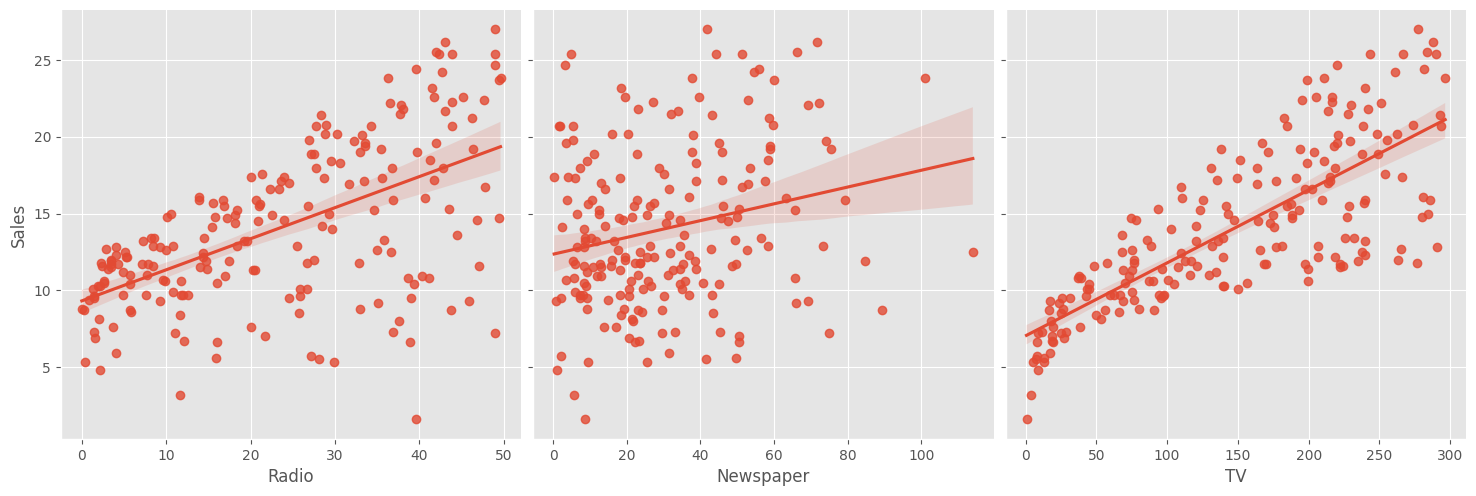

In [306]:
sns.pairplot(
    df,
    y_vars='Sales',
    x_vars=['Radio', 'Newspaper', 'TV'],
    size=5,
    kind='reg',
    diag_kind=None
);

Для начала давайте поговорим только про рекламу на TV. Оценим параметры модели

$$
Sales_i = \beta_0 + \beta_1 \cdot TV_i + \varepsilon_i
$$

In [307]:
import statsmodels.formula.api as smf

model = smf.ols('Sales ~ TV', data=df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Thu, 21 Nov 2024   Prob (F-statistic):           1.47e-42
Time:                        01:11:26   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.0

In [308]:
res.params

Intercept    7.032594
TV           0.047537
dtype: float64

- Переменная $TV$ значима, так как $p$-значение для проверки гипотезы о том, что она равна нулю оказалось очень маленьким, наблюдаемое значение статистики $17.668$. Оно лежит глубоко в хвосте нашего распределения.
- Получившееся уравнение

$$
Sales_i = 7.033 + 0.047 \cdot TV_i
$$

можно проинтерпретировать так, что каждые дополнительные $1000$ долларов, потраченные на рекламу по телевизору, увеличивают продажы на $47.537$ товаров.

> Мы можем так интерпретировать значение коэффициента, если выполняются предпослыки линейной регрессии. Например, первая предпослыка говорит о том, что мы должны были верно специфицировать модель.

Если модель специфицирована неверно, у нас есть проблемы.

> Мы получаем корректные оценки стандартных ошибок в ситуации, когда ошибки независимо одинаково распределены с одинаковой дисперсией. Если это не так, оценки ошибок искажены.

# 2. Парная регрессия в логарифмах

У нашей модели явно есть проблемы со спецификацией. Давайте попробуем их исправить. Если взглянуть на график того, как между собой взаимосвязаны реклама по TV и продажи, можно заметить нелинейную зависимость, похожую на логарифмическую.

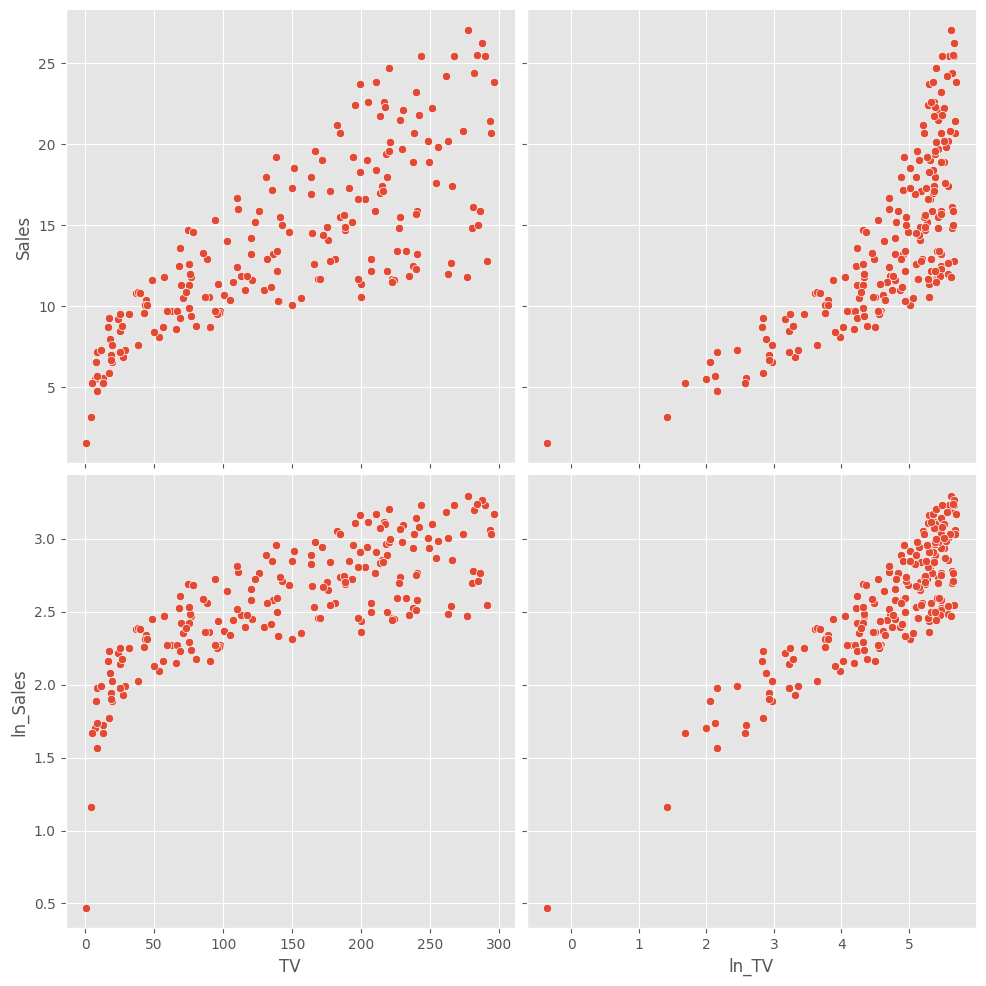

In [309]:
df['ln_TV'] = df['TV'].apply(np.log)
df['ln_Sales'] = df['Sales'].apply(np.log)

sns.pairplot(
    df,
    y_vars=['Sales', 'ln_Sales'],
    x_vars=['TV', 'ln_TV'],
    size=5,
    diag_kind=None
);


Очистим данные от выбросов.

In [310]:
df = df[df.Sales > df.Sales.quantile(0.01)]

Оценим параметры модели

$$
\ln Sales_i = \beta_0 + \beta_1 \cdot \ln TV_i + \varepsilon_i
$$

In [311]:
import statsmodels.formula.api as smf

model = smf.ols('ln_Sales ~ ln_TV', data=df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_Sales   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     435.1
Date:                Thu, 21 Nov 2024   Prob (F-statistic):           1.16e-51
Time:                        01:11:33   Log-Likelihood:                 29.332
No. Observations:                 198   AIC:                            -54.66
Df Residuals:                     196   BIC:                            -48.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9757      0.078     12.443      0.0

Переменная снова значима. $R^2$ подрос. Все коэффициенты в моделях, где целевые и объясняющие переменные взяты в логарифмах, интерпретируются в процентных изменениях. Например, коэффициент $0.3550$ можно проинтерпретировать как то, на сколько процентов увеличутся продажи, при изменении трат на рекламу по телевизору на $1\%$.

# 3. Множественная регрессия

Оценим уравнение

$$
\ln Sales_i = \beta_0 + \beta_1 \cdot \ln TV_i + \beta_2 \cdot Radio_i + \beta_3 \cdot Newspaper_i + \varepsilon_i
$$

In [312]:
model = smf.ols('ln_Sales ~ ln_TV + Radio + Newspaper', data=df)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_Sales   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2959.
Date:                Thu, 21 Nov 2024   Prob (F-statistic):          1.17e-161
Time:                        01:11:43   Log-Likelihood:                 294.22
No. Observations:                 198   AIC:                            -580.4
Df Residuals:                     194   BIC:                            -567.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6661      0.022     30.446      0.0

$F_{st} = \frac{R^{2}/(k-1)}{(1-R^{2}/(n-k)}$
k количество параметров в линейной регрессии.

- Уравнение значимо в целом, значение F-статистики попадает глубоко в хвост
- Коэффициент перед `Newspaper` отрицательный и незначимый

> Если модель специфицирована верно и выполнены все предпосылки, мы можем сделать вывод, что траты на рекламу в газетах никак не повышают продажи и от них можно отказаться

# 4. Проверка предпосылок модели

- Есть ли мультиколинеарность?(линейная зависимость признаков)


In [313]:
df[['ln_TV', 'Radio', 'Newspaper']].corr()

,ln_TV,Radio,Newspaper
ln_TV,1.000000,0.004521,-0.004387
Radio,0.004521,1.000000,0.358916
Newspaper,-0.004387,0.358916,1.000000


Между переменными нет высокой корреляции. Значит у нас получится корректно оценить нашу модель. Есть другие, более формальне критерии для поиска проблем, связанных с мультиколинеарностью, но мы про них говорить не будем.

- Корректны ли данные, с которыми мы работаем, для решения поставленной задачи?
- Корректна ли спецификация модели?
- Есть ли выборосы?

Про всё это мы поговорили выше. Судя по всему, оценки коэффициентов, которые мы получили - несмещённые и состоятельные.

- Есть ли в остатках __автокоррелированность__?

Для проверки этой предпосылки нам достаточно посмотреть в протокол оценивания и найти там строчку `Durbin-Watson`. Это статистика Дарбина-Уотсона. Если она оказывается в районе двух, то автокоррелированности в остатках нет. На самом деле это тоже статистика и для неё есть формальные критические значения, но мы в это углубляться не будем. Есть и другие критерии для проверки этой предпосылки.

- Есть ли в остатках __гетероскедастичность__?

Для гетероскедастичности построим картинку и воспользуемся каким-нибудь критерием.

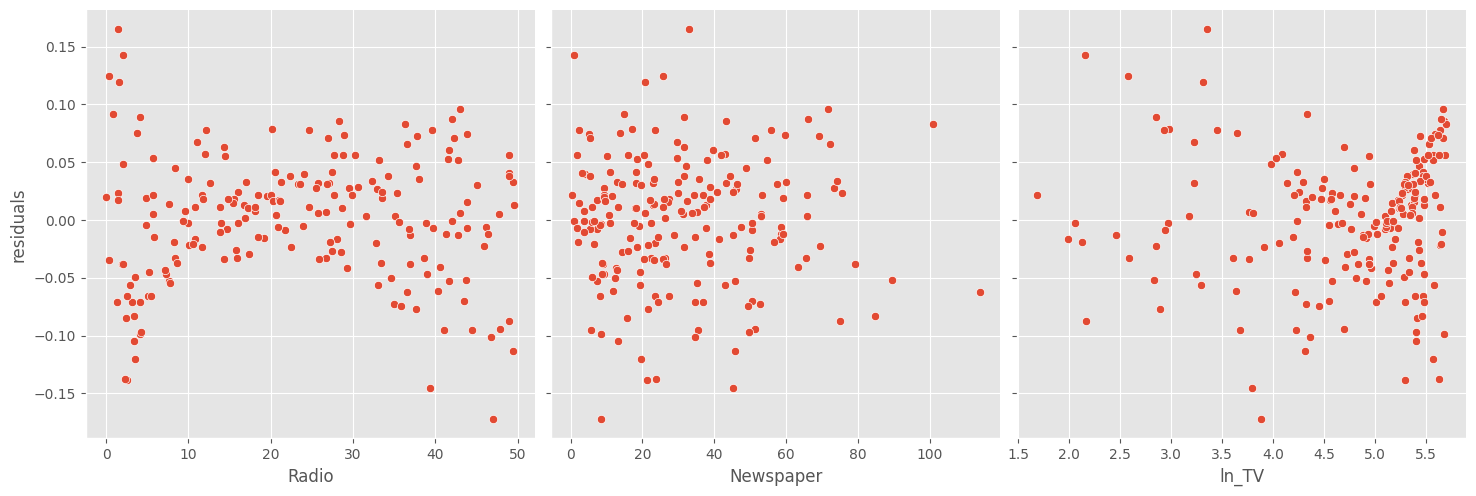

In [314]:
df['residuals'] = res.resid

sns.pairplot(
    df,
    y_vars='residuals',
    x_vars=['Radio', 'Newspaper', 'ln_TV'],
    size=5,
    diag_kind=None
);

Судя по графику, дисперсия ошибок зависит от объёма рекламы по радио. Причём квадратично. Выходит, что оценки дисперсий коэффициентов искажены и доверительные интервалы оказываются смещёнными. Можно провести формальный тест на гомоскедастичность. Таких тестов есть довольно много.

[Breuch Pagan test](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%81%D1%82_%D0%91%D1%80%D0%BE%D0%B9%D1%88%D0%B0_%E2%80%94_%D0%9F%D0%B0%D0%B3%D0%B0%D0%BD%D0%B0)

In [317]:
from statsmodels.stats.diagnostic import het_breuschpagan
het_breuschpagan(res.resid, sm.add_constant(df[['ln_TV', 'Radio', 'Newspaper']]).values)

(np.float64(6.538916813631199),
 np.float64(0.08814029149221943),
 np.float64(2.208542576438612),
 np.float64(0.08842044053086531))

Видим, что `pvalue` пограничен. Гипотеза о гомоскедастичности не отвергается, но не для всех уровней значимости. Здесь лучше полагаться не только на результаты тестов, но и на визуальный анализ и здравый смысл. Можно ввести корректировку и исправить значения ошибок прямо при оценивании модели.

In [318]:
model = smf.ols('ln_Sales ~ ln_TV + Radio + Newspaper', data=df)
res = model.fit(cov_type='HC3')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               ln_Sales   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1807.
Date:                Thu, 21 Nov 2024   Prob (F-statistic):          1.85e-141
Time:                        01:14:10   Log-Likelihood:                 294.22
No. Observations:                 198   AIC:                            -580.4
Df Residuals:                     194   BIC:                            -567.3
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6661      0.029     23.108      0.0

Значения стандартных ошибок изменились. Теперь мы можем использовать их для проверки гипотез.

> Нормальность остатков нам не нужна. Из-за корректировки ошибок мы можем пользоваться только асимптотическими результатами. В данных нет выбросов, поэтому предельные теоремы тут работают.

# 4. Выводы:

1. Тратить деньги на рекламу в газетах неэффективно. Гипотеза о том, что коэффициент перед этой переменной равен нулю, не отвергается.
2. Реклама по телевидению обладает убывающей отдачей от масштаба. Коэффициент перед логарифмом получился меньше единицы. Этот канал оказывается в плане рекламы самым эффективным.
3. Канал, связанный с радио, судя по всему, недоиспользуется. Здравый смысл и микроэкономика подсказывают, что от него тоже логично ожидать убывающую от масштаба отдачу. Однако в данных мы видим, что она линейная.

[Как интерпретировать summary in statmodeels.ols](https://habr.com/ru/articles/681218/)

# Эндогенность

**Проблема неправильной спецификации модели:**
Спецификация модели связана с выбором функциональной формы, которая используется для
анализа взаимосвязей между переменными. Фактически, первое предположение модели регрессии требует, чтобы модель была правильно задана. Другими словами, предполагается, что мы точно знаем, какие
переменные следует включить. Однако на практике никто не может быть абсолютно уверен в том, что выбранная функциональная форма является правильной, поэтому возможны ошибки в спецификации. Прежде всего, есть
две причины их существования:
1) формула неверна;
2)опущена значимая объясняющая переменная

## Simulation of endogenuity: Ommited variable bias

Что будет если не учесть переменную влияющую на Y?

Пусть корректная модель это: $Y =β_0+β_1 X_1 +β_2 X_2+ u$, гауссовский шум $u \sim N(0,1)$

Сгенерируем данные:

In [319]:
import numpy as np
data_size = 100
x_1 =  np.linspace(300, 800, data_size) + np.random.normal(scale = 3, size = data_size)
x_2 = np.linspace(2, 2000, data_size) + np.random.normal(scale = 2, size = data_size)

true_beta_0 = 1
true_beta_1 = 3
true_beta_2 = 5
#generate Y as in model


Предположим исследователь хочет оценить модель линейной регрессии:
$Y =\alpha_0+\alpha_1 X_1 +\epsilon$, не учитывая переменную $X_2$.



In [322]:
import tqdm

In [323]:
import statsmodels.formula.api as smf # Модели
import pandas as pd

beta0_estimate_list = []
beta1_estimate_list = []
for i in tqdm.tqdm(range(2000)):
  Y = true_beta_0 +true_beta_1* x_1+true_beta_2*x_2 + np.random.normal(size = data_size)
  data = pd.DataFrame(np.vstack([x_1, Y]).T, columns=['x', 'Y'])
  model = smf.ols(data=data, formula='Y ~ x').fit()
  beta0_estimate_list.append(model.params[0])
  beta1_estimate_list.append(model.params[1])


100%|██████████| 2000/2000 [00:06<00:00, 321.48it/s]


Text(0.5, 1.0, 'Distribution of beta_1')

<Figure size 1000x1000 with 0 Axes>

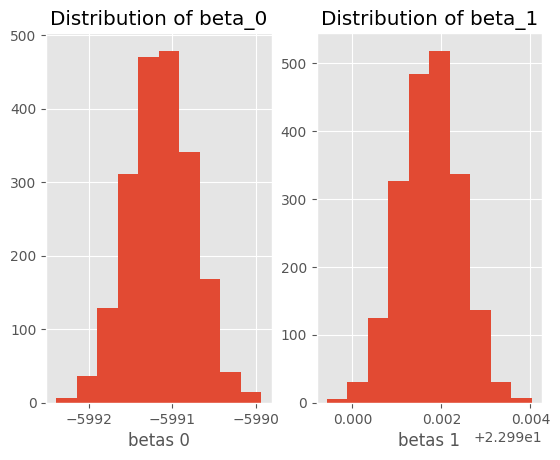

In [324]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
fig,axes = plt.subplots(ncols = 2)

axes[0].hist(beta0_estimate_list)
axes[0].set_xlabel("betas 0")
axes[0].set_title("Distribution of beta_0")

axes[1].hist(beta1_estimate_list)
axes[1].set_xlabel("betas 1")
axes[1].set_title("Distribution of beta_1")


Мы видим, что истинное значение   $\beta_0$  равно  1 не попадало в распределение оценки МНК $\hat \alpha_0$  на $\beta_0$, что  значит что оценка модели $Y =\alpha_0+\alpha_1 X_1 +\epsilon$ через МНК
$\hat \alpha_0$ на  $\beta_0$  ассимтотически смещенная.

Тоже самое, мы видим, что истинное значение   $\beta_1$  равно  3 не попадало в распределение оценки МНК $\hat \alpha_1$  на $\beta_1$, что  значит что оценка модели $Y =\alpha_0+\alpha_1 X_1 +\epsilon$ через МНК
$\hat \alpha_1$ на  $\beta_1$  ассимтотически смещенная.

Почему оценка получается смещенной при отстуствии в моделе важной объясняющей переменной?


Также при проблеме отсутсвующей переменной(omitted variable bias) стандартные ошибки
и тесты становятся невалидны.

Визуализация 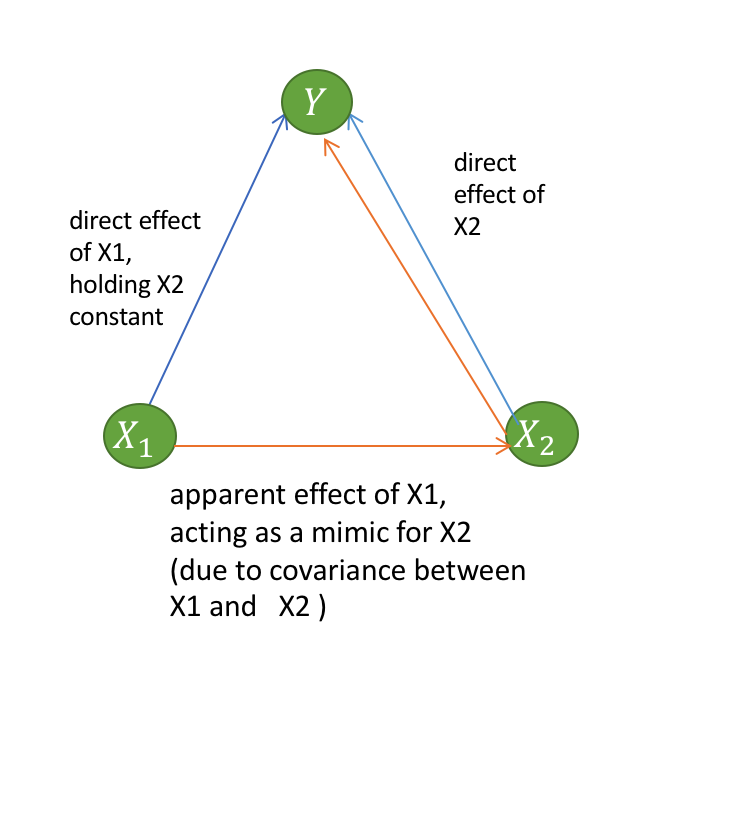

How to identify endogenuity? TSLS Durwin Wu Hausman test.
How to combat endogenuity? Instrumental variable

Если существует проблема с опущенной значимой переменной,
то в модели $Y = \alpha +\beta X + \epsilon$ появляется проблема, когда $ \epsilon$ сколерован с X, что нарушает предпоссылку Гаусса-Маркова о несколерированности остатков и регрессоров.



Мы можем справиться с проблемой эндогенности, применив оценку инструментальных переменных (IV). Инструментальные переменные Допустимая инструментальная переменная $Z$  - это специальная прокси- переменная, для которой должны выполняться следующие условия::
1. Инструмент экзогенность: он не коррелирует с остатком, т. е. $cov(Z,u) = 0$ ;)

2.Инструмент значим: он достаточно сильно коррелирует с соответствующей эндогенной переменной, т. е. $cov(Z,X) \neq 0$.
Основной целью применения инструментов является получение состоятельных оценок параметров.



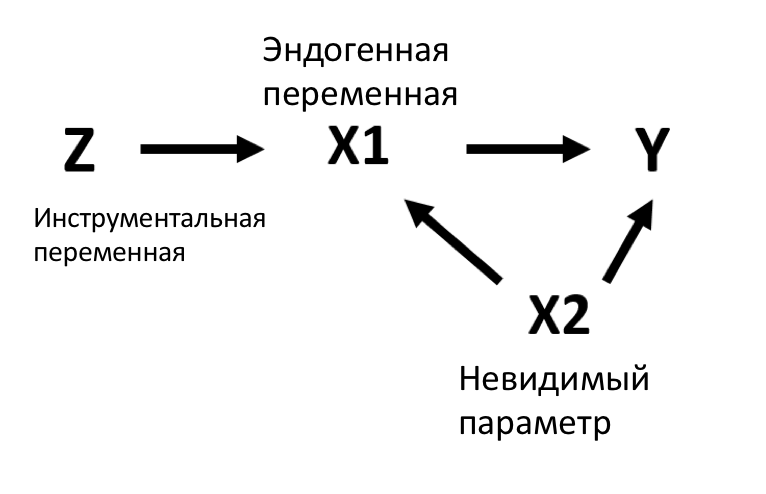

Тогда формула оценки интрументальной переменной (IV)
$\beta^{IV}= \frac{\sum_i(z_i y_i)}{\sum_iz_i x_i}=(Z^{T}X)^{-1}Z^Ty$

**Как выводиться инструментальная оценка?**

По предположению на инструментальную переменную $z$ должно выполняться  условие, что  $E(z_i e_i) = 0$,  где $e_i = y_i - x_i^{T} \beta$ это остаток.

Тогда $E(z_i y_i) - \beta E( z_i x_i^{T}) = 0$ откуда $\beta =(E( z_i x_i^{T}))^{-1} E(z_i y_i)$
Отсюда оценка методом мометнов(заменяя попляционные моменты на выборочные моменты) получается:
$\beta^{IV} = \frac{\frac{1}{n}\sum_i(z_i y_i)}{\frac{1}{n}\sum_i z_i x_i^{T}}$


Частично если переменная экзогенная, то она сама для себя будет инструментом.

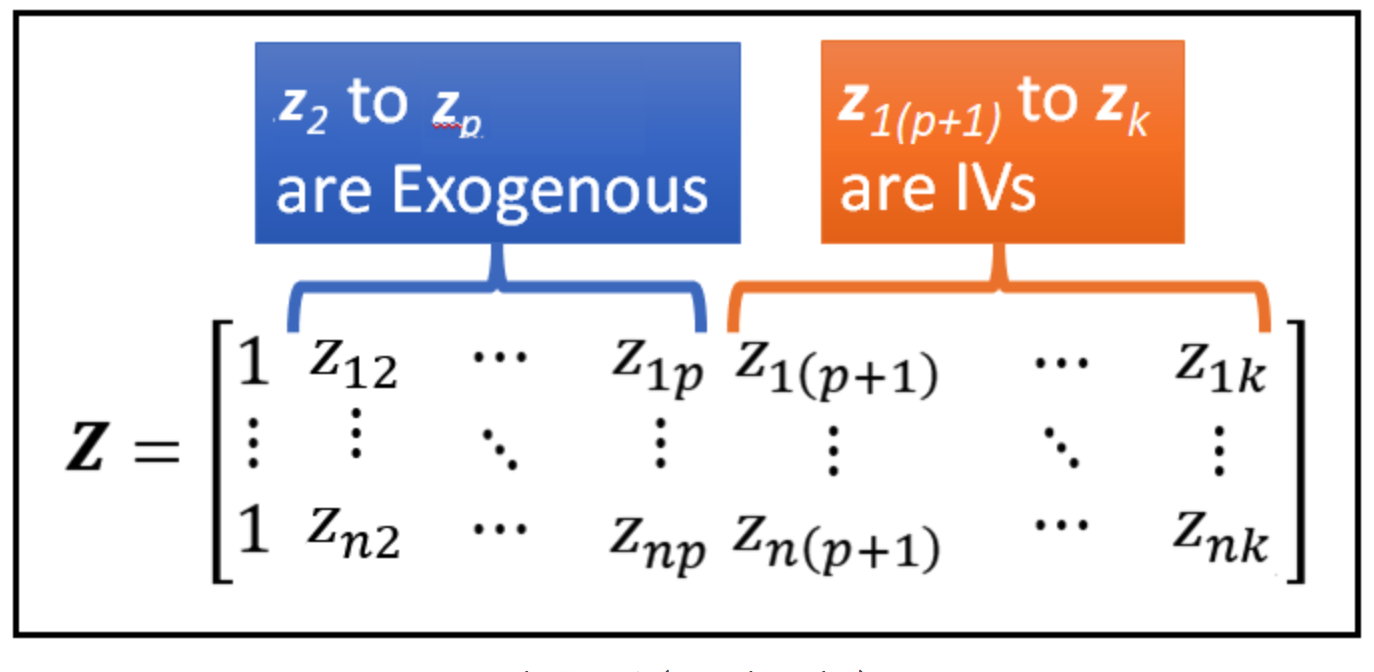

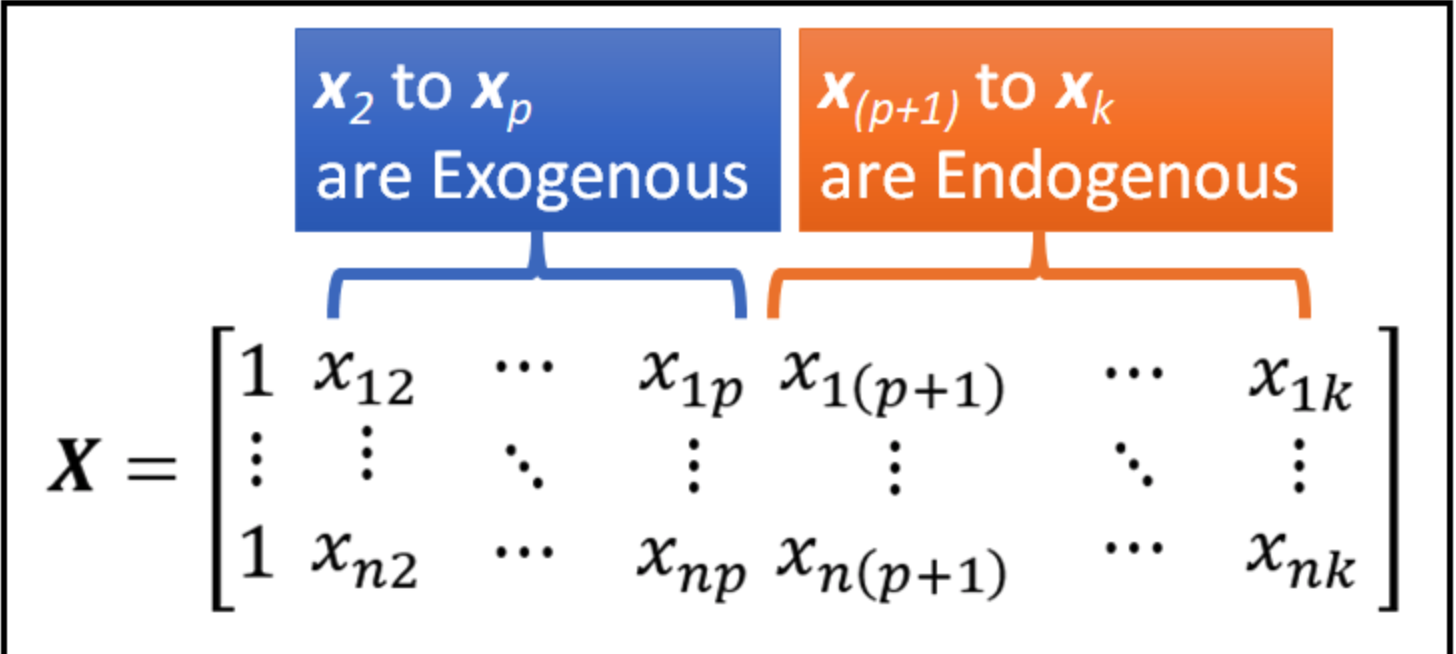

# Задача 2: Пример на инструментальную переменную

In [325]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.api import add_constant
from statsmodels.sandbox.regression.gmm import IV2SLS

In [326]:
import pandas as pd
#Load the Panel Study of Income Dynamics (PSID) into a Dataframe

data = pd.read_csv("https://raw.githubusercontent.com/limph0nimph/psmo_linreg_classes/main/PSID1976.csv")
df_1975 = data.query('participation == \'yes\'')
df_1975['ln_wage'] = np.log(df_1975['wage'])


In [327]:
data.columns

Index(['rownames', 'participation', 'hours', 'youngkids', 'oldkids', 'age',
       'education', 'wage', 'repwage', 'hhours', 'hage', 'heducation', 'hwage',
       'fincome', 'tax', 'meducation', 'feducation', 'unemp', 'city',
       'experience', 'college', 'hcollege'],
      dtype='object')

Predict wage on education experience

We cannot include talant variable into regression as no full information on talant. But talant inbfluences education which imnplies that education will be calculated with the residual(as talant is an ommited variable).




Мы ходим понять как образование и опыт работы влияет на зарплату.
Однако мы также знаем, что важным фактором является талант(Ability), но талант это невидимая переменная и данных на неё у нас нет.

Таким образом, истинная модель выглядит так:
$Log wage=β0+β_1Education+β_2Ability+β_3Experience$

Но мы можем оценить регрессию вида:
$Log wage=\alpha_0+\alpha_1Education+\alpha_2 Experience$

Однако на образовние точно влияет талант(Ability). Тогда получается, что в данный модели будут проблема пропущенной переменной, так как
$cov(Education, Ability)>0$ и в данной регрессионной модели будут смещенные и несостоятельные оценки.

Что же делать, чтобы получить состоятельные оценки на параметры $\alpha_0,\alpha_1, \alpha_2$ можно для переменной Education использовать инструментальные переменные, связанные с Education, но **не** связанные с талантом Ability.

Например, образование родителей в целом определяет образование человека, но не зависит от его таланта(Ability).

Тогда в качестве инструментальных переменных будет использовать meducation(образование матери) и feducation (образование отца)



In [328]:
import numpy as np
X_data = np.stack([np.ones(df_1975.shape[0]), df_1975['education'].values, df_1975['experience'].values]).T
Z_IV = np.stack([ df_1975['feducation'], df_1975['meducation'], df_1975['experience'].values]).T
y = df_1975['ln_wage']
beta_IV =  np.linalg.inv(Z_IV.T@X_data)@Z_IV.T@y
print(beta_IV)

[-1.47317101  0.18330255  0.02345972]


# Задача 4 Как  с помощью инструментальной переменной проверить наличие эндогенности в модели?
**Durbin-Wu-Hausman specification test**

Для проверки гипотезы об эндогенности можно было бы использовать тест Хаусмана. Оригинальный тест основан на сравнении коэффициентов регрессии инструментальных переменных с обычной регрессией OLS с использованием критерия хи-квадрат со степенями свободы, равными количеству
сравниваемых параметров. При нулевой гипотезе об отсутствии одновременного смещения уравнения и OLS, и IV будут согласованными оценками, но OLS будет более эффективным. Согласно альтернативной гипотезе, МНК будут противоречивыми, и это видно из значения теста (значительно отличающегося
коэффициенты двух регрессий). Тест позволяет провести различие между этими двумя возможностями.
$H_0$: разница в коэффициентах не является систематической ((u_i не зависит от регрессоров) правильная спецификация <=> нет эндогенности)

Оценщик $\beta^{OLS}$ непротиворечив при H_1 и эффективен при H_0
Оценщик $\beta^{IV}$ согласован при H_0 и H_1

Однако, если тестовая статистика незначительна, это не обязательно означает, что нулевая гипотеза верна. Возможно, это неверно, но инструменты, используемые в IV, настолько слабы, что различия между оценками IV и OLS несущественны.

Существует другой подход к тесту эндогенности, основанный на методе Дэвидсона-Маккиннона:

1. Оцените исходную модель: $Y = \beta_1+\beta_2 X +u$ ;

2. Оцените регрессию эндогенной переменной на инструменте (инструментах), сохраните остатки: $X = \alpha_1+ \alpha_2 Z +v $, где
$Z$ - это возможный инструмент. Позволь
$resid = X - \hat \alpha_1 - \hat \alpha_2 Z $ - переменная, состоящая
из остатков в этой оценочной регрессии;

3. Добавьте остатки в качестве дополнительного регрессора в исходную модель:
$Y = \beta_1+\beta_2 X + +\beta_3resid+ u$
4. Проверьте значимость коэффициента наклона $\beta_3$. Если эта новая переменная незначительна – значит, разница в коэффициентах не является систематической (оценки OLS согласованы) =>
используйте исходную модель. Если это существенно – значит, разница систематическая, используйте инструментальную переменную.
Это асимптотический тест, и t-статистику следует сравнить с критическими значениями из стандартной нормы.

In [ ]:
#regression of X on instrument
reg_expr = 'education ~ meducation + feducation'
olsr_model_iv = smf.ols(formula=reg_expr, data=df_1975)
olsr_model_iv_results = olsr_model_iv.fit()
print(olsr_model_iv_results.summary())
residual = olsr_model_iv_results.resid

                            OLS Regression Results                            
Dep. Variable:              education   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     55.83
Date:                Fri, 27 Oct 2023   Prob (F-statistic):           2.96e-22
Time:                        23:38:50   Log-Likelihood:                -910.64
No. Observations:                 428   AIC:                             1827.
Df Residuals:                     425   BIC:                             1839.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.4801      0.321     29.523      0.0

In [ ]:
import statsmodels.api as sm
import numpy as np

X = np.stack([np.ones(df_1975.shape[0]), df_1975['education'].values,residual]).T
Y = df_1975['ln_wage']
model = sm.OLS(Y,X,)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ln_wage   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     30.85
Date:                Fri, 27 Oct 2023   Prob (F-statistic):           3.10e-13
Time:                        23:45:11   Log-Likelihood:                -439.10
No. Observations:                 428   AIC:                             884.2
Df Residuals:                     425   BIC:                             896.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5510      0.399      1.380      0.168      -0.234       1.336
x1             0.0505      0.031      1.606      0.109      -0.011       0.112
x2             0.0734      0.035      2.078      0.038       0.004       0.143
==============================================================================
Omnibus:                       87.954   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              278.164
Skew:                          -0.930   Prob(JB):                     3.96e-61
Kurtosis:                       6.484   Cond. No.                         158.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Видим, что коэффициент при $x_2$(residual) значим, так как t-статистика не входит в доверительный интервал,

Так как коэффициент значим, это показывает, что имеет место быть проблемв эндогенности.

# Задача 5 Монте Карло по оценки инструментальной переменной

Experiment on generated data:



look at different distributions of beta instrumental variable estimator
for different sample size

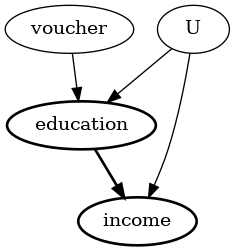

In [ ]:
import seaborn as sns
beta_iv_dist = []
beta_ols_dist = []
for i in range(1000):
  n_points = 1000
  education_abilty = 1
  education_voucher = 2
  income_abilty = 2
  income_education = 4


  # confounder
  ability = np.random.normal(0, 3, size=n_points)

  # instrument
  voucher = np.random.normal(2, 1, size=n_points)

  # treatment
  education = np.random.normal(5, 1, size=n_points) + education_abilty * ability +\
              education_voucher * voucher

  # outcome
  income = np.random.normal(10, 3, size=n_points) +\
          income_abilty * ability + income_education * education

  # build dataset (exclude confounder `ability` which we assume to be unobserved)
  data = np.stack([education, income, voucher]).T
  df = pd.DataFrame(data, columns = ['education', 'income', 'voucher'])

  Z_IV =  np.stack([np.ones(n_points),df["voucher"].values]).T
  X_data =  np.stack([np.ones(n_points), df["education"].values]).T
  y = df["income"].values
  beta_IV =  np.linalg.inv(Z_IV.T@X_data)@Z_IV.T@y
  beta_iv_dist.append(beta_IV[1])
  beta_ols = sm.OLS(y,X_data).fit().params[1]
  beta_ols_dist.append(beta_ols)


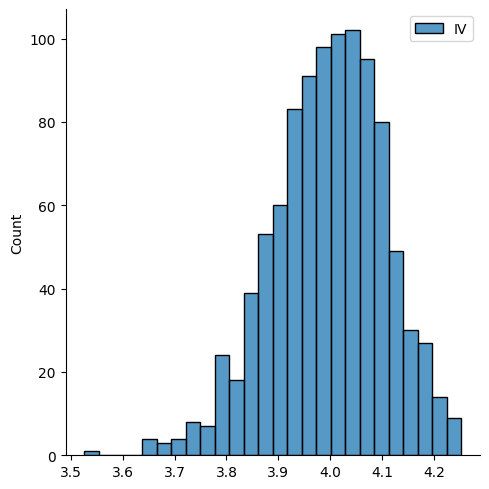

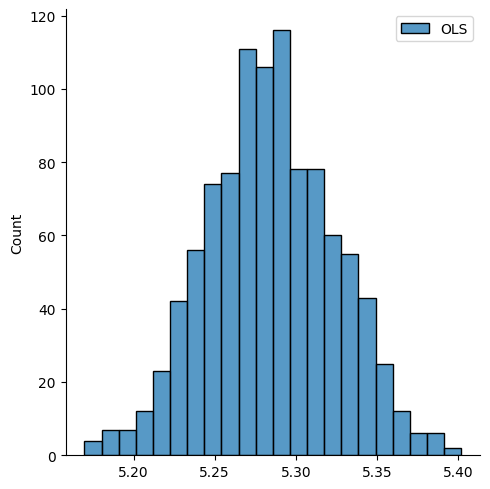

In [ ]:
import matplotlib.pyplot as plt

sns.displot(beta_iv_dist,label = "IV")
plt.legend()
sns.displot(beta_ols_dist,label = "OLS")
plt.legend()

Видим, что оцнка инструментальной преременной центрирована около 4, что является инстинным значением параментра income_education.
В отличие от нее, оценка методом OLS в условиях эндогенноссти, видно , что смещена и несостоятельна.